Notebook by: Eunice Ngai

# Set Up

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

## Helper Functions

In [ ]:
def show_quote_and_labels(num = 10, df=pd.DataFrame(), quote_col = ['quote'], label_col = ['label']):
  '''
  Print randomly selected labels and quotes from the data.
  '''
  df_tmp = df[label_col + quote_col].sample(n=num)
  for i in range(len(df_tmp)):
    for j in label_col + quote_col:
      if j == 'label':
        print(j.title(), ': ', df_tmp.iloc[i].loc[j])
      else:
        print(j.title(), ':\n', df_tmp.iloc[i].loc[j])
    print('-' * 60)

# Load Data

In [ ]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

df.info()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Index: 6091 entries, 0 to 6436
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   quote      6091 non-null   object
 1   label      6091 non-null   object
 2   source     6091 non-null   object
 3   url        6091 non-null   object
 4   language   6091 non-null   object
 5   subsource  1796 non-null   object
 6   id         0 non-null      object
dtypes: object(7)
memory usage: 380.7+ KB


# Mini-EDA

<ipython-input-4-9063702b583f>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=90)


[Text(0, 0, '5_science_unreliable'),
 Text(1, 0, '1_not_happening'),
 Text(2, 0, '4_solutions_harmful_unnecessary'),
 Text(3, 0, '0_not_relevant'),
 Text(4, 0, '6_proponents_biased'),
 Text(5, 0, '7_fossil_fuels_needed'),
 Text(6, 0, '2_not_human'),
 Text(7, 0, '3_not_bad')]

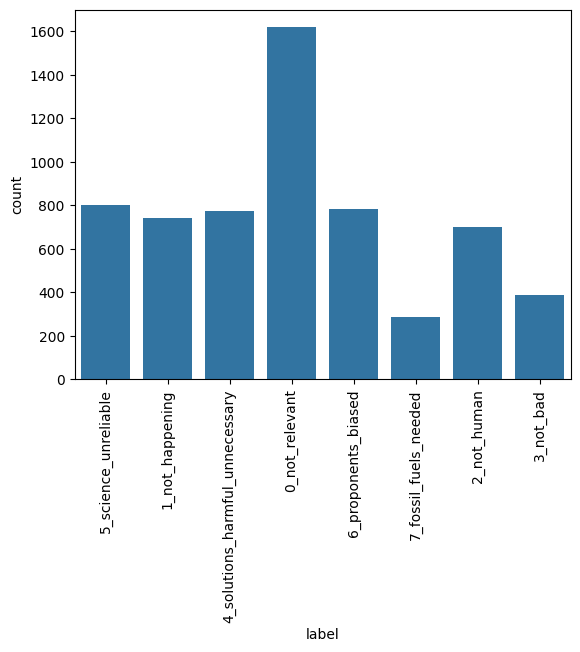

In [ ]:
label_dist = sns.countplot(x='label', data=df)
label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=90)

# Text Augmentation

In [ ]:
# find out how many sentences need to be translated and back-translated to reach  800, per category label
target_num = 800

for category in df['label'].unique():
  if df['label'].value_counts()[category] < target_num:
    missing = target_num - df['label'].value_counts()[category]
    print(category,missing)


1_not_happening 59
4_solutions_harmful_unnecessary 26
6_proponents_biased 18
7_fossil_fuels_needed 513
2_not_human 98
3_not_bad 414


In [ ]:
# Target number of sentences per class
target_count= 800
# target_count = df[df['label']=='7_fossil_fuels_needed'].shape[0]*2
label_counts = df['label'].value_counts()
missing_counts = {label: max(0, target_count - count) for label, count in label_counts.items()}

print(missing_counts)

missing_sentences = pd.DataFrame(columns=['sample_quote', 'label'])

for label, missing_count in missing_counts.items():
    label_df = df[df['label'] == label]
    sampled_df = label_df.sample(n=min(missing_count, len(label_df)), replace=False)  # seed is not set, the sentences are different from Juliana's
    missing_sentences = pd.concat([missing_sentences, sampled_df.rename(columns={'quote': 'sample_quote'})], ignore_index=True)


print(len(missing_sentences))

{'0_not_relevant': 0, '5_science_unreliable': 0, '6_proponents_biased': 18, '4_solutions_harmful_unnecessary': 26, '1_not_happening': 59, '2_not_human': 98, '3_not_bad': 414, '7_fossil_fuels_needed': 513}
874


In [ ]:
show_quote_and_labels(num = 10, df=missing_sentences, quote_col = ['sample_quote'], label_col = ['label'])

Label :  3_not_bad
Sample_Quote :
 Modest changes in temperature are not about to wipe them [coral reefs] out. Neither will increased carbon dioxide, which is a fundamental chemical building block that allows coral reefs to exist at all. It is their and our friend, generally, not the enemy.
------------------------------------------------------------
Label :  1_not_happening
Sample_Quote :
 Their has been no statistically significant warming of the upper ocean since 2003.
------------------------------------------------------------
Label :  7_fossil_fuels_needed
Sample_Quote :
 I see over here: ‘Trump digs coal,’” he said. “That’s true. I do.” He went on to promise an increase in coal mining jobs by repealing Obama’s “ridiculous rules and regulations.
------------------------------------------------------------
Label :  7_fossil_fuels_needed
Sample_Quote :
 Gas and oil are constantly being created and never run out.
------------------------------------------------------------
Label :  

# Translate Some Sentences into Chinese and Back

model: [Multilingual Bart](https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt)

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast


model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [ ]:
def mbart_translator(text='Hello, World!', src_lang='en_XX', tar_lang='zh_CN'):
  '''
  Translate the input text into the target language.
  args:
  text - string; The text to be translated in the source language.
  src_lang - string; zh_CN for Chinese or en_XX for English; The source language of the text to be translated.
  tar_lang - string; zh_CN for Chinese or en_XX for English; The language that the input text to be translated into.
  return:
  trns_text - string; The text in target language.
  '''
  article = text
  tokenizer.src_lang = src_lang
  encoded_en = tokenizer(article, return_tensors="pt")
  generated_tokens = model.generate(
      **encoded_en,
      forced_bos_token_id=tokenizer.lang_code_to_id[tar_lang]
  )
  trns_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

  return trns_text[0]

## Sample Sentences
**Sample 1 (Load time ~30s single translation)**  
*CO2 cannot cause global warming. I’ll tell you why. It doesn’t mix well with the atmosphere, for one. For two, its specific gravity is 1 1/2 times that of the rest of the atmosphere. It heats and cools much quicker. Its radiative processes are much different. So it cannot – it literally cannot cause global warming.*  
**Issues**
1. keyword CO2 is missing in the backward translation.
2. Perfect Chinese translation.  

**Sample 2 (Same as Juliana's. Load time ~30s single translation)**  
*"Fun fact: 0 people have ever died from climate change. That number is expected to remain constant*  
**Issues**
1. 'Fun fact' is missing from the backward translation.
2. Perfect Chinese translation.

In [ ]:
article_en = '''
              CO2 cannot cause global warming. I’ll tell you why. It doesn’t mix well with the atmosphere, for one. For two, its specific gravity is 1 1/2 times that of the rest of the atmosphere. It heats and cools much quicker. Its radiative processes are much different. So it cannot – it literally cannot cause global warming.
              '''

# translate English to Chinese
tokenizer.src_lang = "en_XX"
encoded_en = tokenizer(article_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["zh_CN"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


['二氧化碳不能引起全球变暖。我告诉你为什么。它与大气层不很好地混合。对于两个来说,它的特定重力是其他大气层的1 1/2倍。它能更快地加热和冷却。它的辐射过程非常不同。因此它不能 — 它实际上不能引起全球变暖。']

In [ ]:
article_zh = '''
              二氧化碳不能引起全球变暖。我告诉你为什么。它与大气层不很好地混合。对于两个来说,它的特定重力是其他大气层的1 1/2倍。它能更快地加热和冷却。它的辐射过程非常不同。因此它不能 — 它实际上不能引起全球变暖。
              '''

# translate English to Chinese
tokenizer.src_lang = "zh_CN"
encoded_en = tokenizer(article_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['It doesn’t mix well with the atmosphere, for one. For two, its specific gravity is 1 1/2 times that of the rest of the atmosphere. It heats and cools much quicker. Its radiative processes are much different. So it cannot – it literally cannot cause global warming.']

In [ ]:
article_en = '''
              Fun fact: 0 people have ever died from climate change. That number is expected to remain constant
              '''

# translate English to Chinese
tokenizer.src_lang = "en_XX"
encoded_en = tokenizer(article_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["zh_CN"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['有趣的事实:有0人死于气候变化,这一数字预计将保持不变']

In [ ]:
article_zh = '''
              有趣的事实:有0人死于气候变化,这一数字预计将保持不变
              '''

# translate English to Chinese
tokenizer.src_lang = "zh_CN"
encoded_en = tokenizer(article_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['0 people have ever died from climate change. That number is expected to remain constant']

## Unit Test

In [ ]:
# new col (cn_quote): map the mbart_translator to the sample_quote (EN -> CN)
missing_sentences['cn_quote'] = missing_sentences.iloc[:1]['sample_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='en_XX', tar_lang='zh_CN')
                                                 )
# new col (aug_quote): map the mbart_translator to cn_quote (CN -> EN)
missing_sentences['bt_quote'] = missing_sentences.iloc[:1]['cn_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='zh_CN', tar_lang='en_XX')
                                                 )
# new col (connection): store the connection with the original quote bt_[index]

In [ ]:
missing_sentences.iloc[:1]

,sample_quote,label,source,url,language,subsource,id,cn_quote,bt_quote
0,"These people [the EPA] are just psychotic, tha...",6_proponents_biased,Desmog,https://www.desmog.com/brian-g-valentine/,en,None,None,"这些人(美国环保局)只是精神病患者,没别的说法了...... 美国不需要被精神病者控制;那些...",There is no need for the United States to be c...


In [ ]:
# check translations
show_quote_and_labels(num = 1, df=missing_sentences.iloc[:1], quote_col = ['sample_quote', 'cn_quote', 'bt_quote'], label_col = ['label'])

Label :  6_proponents_biased
Sample_Quote :
 These people [the EPA] are just psychotic, that’s all, there’s no other word for it… . The United States doesn’t need to be governed by psychopaths; people who have lost their minds and all sense of proportion have no business telling other people what to do.
Cn_Quote :
 这些人(美国环保局)只是精神病患者,没别的说法了...... 美国不需要被精神病者控制;那些失去头脑和所有比例感的人没有责任告诉别人该做什么。
Bt_Quote :
 There is no need for the United States to be controlled by psychopaths; those who lose their minds and sense of proportion are not responsible for telling others what to do.
------------------------------------------------------------


## Translating 10 Entries

In [ ]:
# new col (cn_quote): map the mbart_translator to the sample_quote (EN -> CN)
missing_sentences['cn_quote'] = missing_sentences.iloc[:10]['sample_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='en_XX', tar_lang='zh_CN')
                                                 )
# new col (aug_quote): map the mbart_translator to cn_quote (CN -> EN)
missing_sentences['bt_quote'] = missing_sentences.iloc[:10]['cn_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='zh_CN', tar_lang='en_XX')
                                                 )
# new col (connection): store the connection with the original quote bt_[index]

In [ ]:
# check translations
show_quote_and_labels(num = 10, df=missing_sentences.iloc[:10], quote_col = ['sample_quote', 'cn_quote', 'bt_quote'], label_col = ['label'])

Label :  6_proponents_biased
Sample_Quote :
 First, we need to assess the scope of the problem. We have commissioned a major new study to determine what kids are being taught. Is climate indoctrination universal? Or is it worse in some places than others? […] The second part of our plan is to use our national assessment study to identify the worst offenders. […] The third part of our plan is a public policy solution.
Cn_Quote :
 首先,我们需要评估问题的范围。我们已经委托了一项重大的新研究,以确定儿童正在接受什么教育。气候灌输是普遍的吗?还是在某些地方比其他地方更糟糕吗?
Bt_Quote :
 First, we need to assess the scope of the problem. We have commissioned a major new study to determine what education children are receiving. Is climate irrigation universal, or is it worse in some places than in others?
------------------------------------------------------------
Label :  6_proponents_biased
Sample_Quote :
 You know, it has been said by some that you are right on the extreme fringe. Well, hey, somebody occasionally has to stand out a little bit from the crowd 

## Translating All Entries

In [ ]:
# new col (cn_quote): map the mbart_translator to the sample_quote (EN -> CN)
missing_sentences['cn_quote'] = missing_sentences['sample_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='en_XX', tar_lang='zh_CN')
                                                 )
# new col (aug_quote): map the mbart_translator to cn_quote (CN -> EN)
missing_sentences['bt_quote'] = missing_sentences['cn_quote'].map(
     lambda x: mbart_translator(text=x, src_lang='zh_CN', tar_lang='en_XX')
                                                 )
# new col (connection): store the connection with the original quote bt_[index]
missing_sentences['connection'] = missing_sentences.index.map(lambda x: f'bt_{x}')

In [ ]:
missing_sentences.to_csv('/content/drive/MyDrive/MIDS/FrugalAI/Eunice/missing_sentences_1.csv')